In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from IPython import display 
from scipy import stats
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit, optimize, minimize_scalar, root


import pickle
import dask

## To Do:

1. Calculate the edges of footprint

2. Assign an id to each galaxy using formula below

3. Store sweep from which a cluster came from

4. Moving up through the sweeps, assign a tuple of clusterid and membership probability to each galaxy in our dataset (dictionary). If clusterid already assigned, replace only if probability of new cluster is higher. 

5. Output every 10 groups. 

In [2]:
test1 = np.array([1, 2, 3])
test2 =  np.array([1, 2, 4])
test3 =  np.array([1, 2, 5])
np.concatenate((test1.reshape((1, len(test1))), test2.reshape((1, len(test1)))), axis = 0).T
#dict(zip(test1, zip(test2, test3)))

array([[1, 1],
       [2, 2],
       [3, 4]])

In [15]:
with open("Data/sweep-000m005-010p000_trim.pkl", "rb") as f:
    ra_dec = pickle.load(f)

In [16]:
ra_dec = ra_dec[np.logical_or(ra_dec.MASKBITS == 0, ra_dec.MASKBITS == 4096)]
ra_dec = ra_dec[np.logical_or(np.logical_or(ra_dec.gaia_phot_g_mean_mag > 19, ra_dec.gaia_astrometric_excess_noise > 10**.5), ra_dec.gaia_astrometric_excess_noise==0)]

ra_dec["magR"] = 22.5-2.5*np.log10(ra_dec.FLUX_R)
ra_dec["magZ"] = 22.5-2.5*np.log10(ra_dec.FLUX_Z)
ra_dec["magW1"] = 22.5-2.5*np.log10(ra_dec.FLUX_W1)
l_mask = (ra_dec.magR - ra_dec.magW1) > 1.8*(ra_dec.magR-ra_dec.magZ)-0.6
l_mask[~np.isfinite(l_mask)] = False
#ra_dec = ra_dec[np.logical_or(l_mask, ra_dec.magR-ra_dec.magZ < 1)]
ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.z_phot_median>0.01)]
ra_dec["RA_r"] = (np.pi/180)*ra_dec["RA"]
ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]
ra_dec["gid"] = np.round(ra_dec.RA, 6)*10**16 + np.round(ra_dec.DEC + 90, 6)*10**6

ra_dec.reset_index(inplace = True, drop = True)

oversample = 30
over = np.array([ra_dec.z_phot_median.values]).T*np.ones((len(ra_dec), oversample))
sigma = np.array([ra_dec.z_phot_std.values]).T*np.ones((len(ra_dec), oversample))
random = np.random.normal(loc = 0, scale = 1, size = (len(ra_dec), oversample))
gauss = over + sigma*random
ra_dec["gauss_z"] = pd.Series(list(gauss))

ra_dec["y"] = ra_dec["DEC_r"] - np.mean(ra_dec["DEC_r"]) + 50
ra_dec["x"] = (ra_dec["RA_r"] - np.mean(ra_dec["RA_r"]))*np.cos(ra_dec["DEC_r"]) + 50

In [17]:
cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
z_array = np.linspace(1e-2, ra_dec.z_phot_median.max(), 500)
sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")

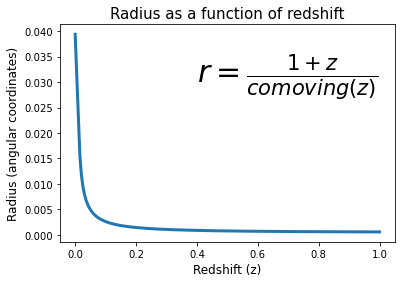

In [18]:
plt.plot(np.linspace(0, 1, 10000), radius_threshold(np.linspace(0, 1, 10000)), "-", lw = 3)
plt.title("Radius as a function of redshift", fontsize = 15)
plt.ylabel("Radius (angular coordinates)", fontsize = 12)
plt.xlabel("Redshift (z)", fontsize = 12)
string = r"$r = \frac{1+z}{comoving(z)}$"
plt.text(0.4, 0.03, s = string, fontsize = 30)
plt.show()

In [19]:
ra_dec.z_phot_median.min()

0.010400183498859406

In [20]:
radius_threshold(0.05)*180/np.pi

0.2844978614147033

In [21]:
median = stats.binned_statistic(ra_dec.z_phot_median, ra_dec.z_phot_std, "median", bins = np.linspace(0.05, ra_dec.z_phot_median.max(), 100))
bins = np.linspace(0.05, ra_dec.z_phot_median.max(), 99)
z_threshold = interp1d(bins, median[0], kind = "linear", fill_value = "extrapolate")

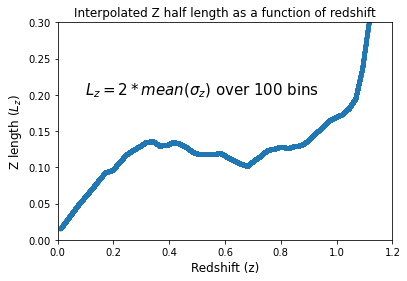

In [22]:
plt.plot(ra_dec.z_phot_median, 2*z_threshold(ra_dec.z_phot_median), ".")
plt.xlim(0, 1.2)
plt.ylim(0, 0.3)
plt.title("Interpolated Z half length as a function of redshift",  fontsize = 12)
plt.ylabel("Z length ($L_z$)",  fontsize = 12)
plt.xlabel("Redshift (z)",  fontsize = 12)
string = r"$L_z = 2* mean(\sigma_z)$ over 100 bins"
plt.text(0.1, 0.2, s = string, fontsize = 15)
plt.show()

In [23]:
massive_sample = ra_dec[ra_dec.mass > 11.2].copy()
massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
massive_sample["local_neighbor_mass"] = np.zeros(len(massive_sample))
massive_sample["ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
massive_sample["corrected_neighbor_mass"] = np.zeros(len(massive_sample))
massive_sample["neighbors"] = np.zeros(len(massive_sample))
massive_sample["local_neighbors"] = np.zeros(len(massive_sample))
massive_sample["ultra_local_neighbors"] = np.zeros(len(massive_sample))
massive_sample["neighbor_gids"] = np.empty((len(massive_sample)), dtype = "object")
massive_sample.reset_index(inplace=True, drop = True)

In [24]:
tree = spatial.cKDTree(ra_dec[["x", "y"]], copy_data = True)
#tree2 = spatial.cKDTree(gauss[["x", "y"]], copy_data = True)

In [25]:
a = 1.3620186928378857  
b = 9.968545069745126
j= 1.04935943 
k = 0.39573094 
l = 0.28347756
def mass_limit(z):
    return np.minimum((a*z + b), 11.2)

def mass_coefficient(z):
    return np.exp(j*z**2 + k*z + l)

In [26]:
radius = 1
small_radius = 0.5
mini_radius = 0.1

pbar = display.ProgressBar(len(massive_sample)-1)
pbar.display()
indexable = ra_dec[["z_phot_median", "x", "y", "mass", "gauss_z", "gid"]].values.copy()

iterrator = massive_sample.copy()
for i, row in iterrator.iterrows():
    neighbors = tree.query_ball_point([row.x, row.y], radius_threshold(row.z_phot_median))
    if len(neighbors) > 0:
        local_data = indexable[neighbors]
        
        z_c = z_threshold(row.z_phot_median)
        cylinder = np.abs(np.vstack(local_data[:, 4]) - row.z_phot_median)
        weight_array = cylinder < 2*z_c
        weights = weight_array.sum(axis = 1)/oversample
        
        approx_cluster = np.append(local_data, np.reshape(weights, newshape = (len(weights), 1)), axis = 1)
        cluster = approx_cluster[approx_cluster[:, -1] > 0]
        
        r_smaller = radius_threshold(row.z_phot_median)
        small_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2).astype(float)) < 0.5*r_smaller]
        mini_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2).astype(float)) < 0.1*r_smaller]
        
        massive_sample.at[i, "neighbors"] = np.sum(cluster[:, -1])
        massive_sample.at[i, "local_neighbors"] = np.sum(small_cluster[:, -1])
        massive_sample.at[i, "ultra_local_neighbors"] = np.sum(mini_cluster[:, -1])
        
        massive_sample.at[i, "neighbor_mass"] = np.log10(np.sum(np.append((10**cluster[:, 3])*cluster[:, -1], [10**row.mass])))
        c_mask = cluster[:, 3]>mass_limit(row.z_phot_median)
        cluster_limited = cluster[c_mask.astype("bool"), :]
        massive_sample.at[i, "corrected_neighbor_mass"] = np.log10(np.sum(np.append(((10**cluster_limited[:, 3]))*cluster_limited[:, -1], [10**row.mass]))*mass_coefficient(row.z_phot_median))
        massive_sample.at[i, "local_neighbor_mass"] = np.log10(np.sum(np.append((10**small_cluster[:, 3])*small_cluster[:, -1], [10**row.mass])))
        massive_sample.at[i, "ultra_local_neighbor_mass"] = np.log10(np.sum(np.append((10**mini_cluster[:, 3])*mini_cluster[:, -1], [10**row.mass])))
        
        clusterid = np.ones((1, len(cluster)))*row.gid
        membership = np.concatenate((cluster[:, -2].reshape((1, len(cluster))), clusterid, cluster[:, -1].reshape((1, len(cluster)))), axis = 0).T
        massive_sample.at[i, "neighbor_gids"] = membership
        
    
    pbar.progress = i

[============================================================] 35384/35384

In [27]:
bins = np.arange(0.05, massive_sample.z_phot_median.max(), 0.01)
binned = [massive_sample[np.logical_and(massive_sample.z_phot_median>=i-.025, massive_sample.z_phot_median<=i+.025)].copy() for i in bins]
clusters = pd.DataFrame()
threshold1 = np.empty(len(binned))
threshold2 = np.empty(len(binned))
for i in range(len(binned)):
    threshold1[i] = np.mean(binned[i].neighbors) + 1.8*np.sqrt(np.mean(binned[i].neighbors))
    threshold2[i] = np.mean(binned[i].local_neighbors) + 1.2*np.sqrt(np.mean(binned[i].local_neighbors))

In [28]:
thresh1 = interp1d(bins, threshold1, kind = "linear", fill_value = "extrapolate")
thresh2 = interp1d(bins, threshold2, kind = "linear", fill_value = "extrapolate")

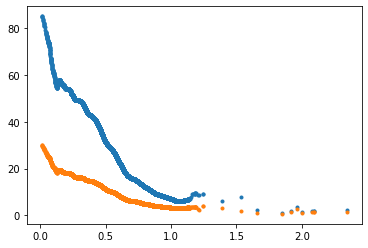

In [29]:
graph1 = thresh1(massive_sample.z_phot_median)
graph2 = thresh2(massive_sample.z_phot_median)
plt.plot(massive_sample.z_phot_median, graph1, ".")
plt.plot(massive_sample.z_phot_median, graph2, ".")
plt.show()

In [30]:
clusters = massive_sample[np.logical_and(massive_sample.neighbors >= thresh1(massive_sample.z_phot_median), massive_sample.local_neighbors >= thresh2(massive_sample.z_phot_median))].copy()

In [31]:
len(clusters)

2535

In [32]:
clusters.sort_values("local_neighbor_mass", inplace = True, ascending = False)
clusters.reset_index(inplace= True, drop = True)

In [33]:
tree = spatial.cKDTree(clusters[["x", "y"]], copy_data = True)

In [34]:
pbar = display.ProgressBar(len(clusters)-1)
pbar.display()
clusters["ncluster"] = np.zeros(len(clusters))
clusternum = 1

iterrator = clusters.copy()
for i, row in iterrator.iterrows():
    if clusters.iloc[i].ncluster == 0:
        clusters.at[i, "ncluster"] = clusternum
        neighbors = tree.query_ball_point([row.x, row.y], 1.5*radius_threshold(row.z_phot_median))
        for index in neighbors:
            if clusters.at[index, "ncluster"] == 0 and np.abs(clusters.at[index, "z_phot_median"] - row.z_phot_median) < 2*z_threshold(row.z_phot_median):
                clusters.at[index, "ncluster"] = clusternum
                clusters.at[i, "neighbor_gids"] = np.concatenate((clusters.at[i, "neighbor_gids"], clusters.at[index, "neighbor_gids"]), axis = 0)
            
        clusternum += 1
    
    pbar.progress = i

[============================================================] 2534/2534

In [35]:
cluster_center = clusters.sort_values(by = ['ncluster','ultra_local_neighbor_mass'], ascending = [True, False]).groupby('ncluster').head(1).copy()

In [36]:
len(cluster_center)

901

In [38]:
membership = pd.DataFrame(cluster_center.neighbor_gids.values)
membership_data = np.zeros((1, 3))
testing = np.zeros((len(cluster_center), 3))

In [39]:
for i in range(0, len(membership)):
    temp = np.stack(membership.values[i])[0]
    membership_data = np.concatenate([membership_data, temp], axis = 0)

In [63]:
membershippd = pd.DataFrame(membership_data[1:], columns = ["galaxy", "cluster", "prob"], dtype = float)

In [64]:
membershippd.sort_values("prob", ascending = False, inplace = True)
membershippd.drop_duplicates(subset = "galaxy", inplace = True)
membershippd.reset_index(inplace = True, drop = True)

In [65]:
membershippd.shape

(54456, 3)

In [69]:
np.round(membershippd.at[111, "galaxy"]/1e16, 15)

5.722751008552877

In [71]:
(membershippd.at[100, "galaxy"] - np.round(membershippd.at[100, "galaxy"]/1e16, 7)*1e16)/1e6 - 90

-4.438496000000001

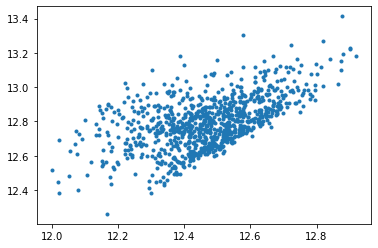

In [25]:
plt.plot(cluster_center.neighbor_mass, cluster_center.corrected_neighbor_mass, ".")
plt.show()

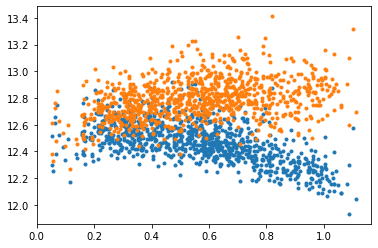

In [25]:
plt.plot(cluster_center.z_phot_median, cluster_center.neighbor_mass, ".")
plt.plot(cluster_center.z_phot_median, cluster_center.corrected_neighbor_mass, ".")
plt.show()

# Crossmatching

In [42]:
redmapper = fits.open("redmapper_dr8_public_v6.3_catalog.fits.gz")
redmapper.info()
redmap = redmapper[1]
from astropy.table import Table
dat = Table.read('redmapper_dr8_public_v6.3_catalog.fits.gz', format='fits')
dat.remove_columns(["P_CEN", "RA_CEN", "DEC_CEN", "ID_CEN", "PZBINS", "PZ"])
df = dat.to_pandas()

Filename: redmapper_dr8_public_v6.3_catalog.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     77   26111R x 30C   [J, 20A, D, D, E, E, E, E, E, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5K, 21E, 21E]   


In [43]:
c = SkyCoord(ra=cluster_center.RA.to_numpy()*u.degree, dec=cluster_center.DEC.to_numpy()*u.degree)
catalog = SkyCoord(ra=df.RA.to_numpy()*u.degree, dec=df.DEC.to_numpy()*u.degree)

max_sep = 5.0 * u.arcmin
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

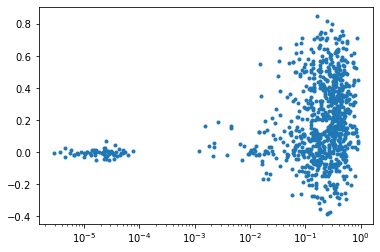

In [44]:
plt.semilogx(d2d.value, cluster_center.z_phot_median.to_numpy()-df.iloc[idx].Z_LAMBDA.to_numpy(), ".")
plt.show()

In [58]:
dfr = df[np.logical_and(np.logical_and(df.RA<cluster_center.RA.max(), df.RA>cluster_center.RA.min()), np.logical_and(df.DEC<cluster_center.DEC.max(), df.DEC>cluster_center.DEC.min()))]
max_sep = 5.0 * u.arcmin
catalog = SkyCoord(ra=dfr.RA.to_numpy()*u.degree, dec=dfr.DEC.to_numpy()*u.degree)
idx, d2d, d3d = catalog.match_to_catalog_sky(c)
sep_constraint = d2d < max_sep
catalog_matches = catalog[sep_constraint]
c_matches = c[idx[sep_constraint]]

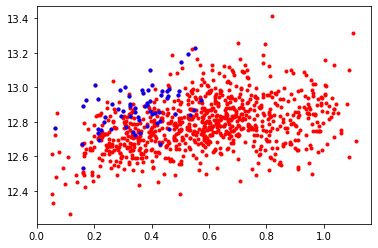

In [74]:
plt.plot(cluster_center.z_phot_median, cluster_center.corrected_neighbor_mass, ".r")
plt.plot(cluster_center.iloc[idx][d2d.value < 10e-4].z_phot_median, cluster_center.iloc[idx][d2d.value < 10e-4].corrected_neighbor_mass, ".b")
plt.show()

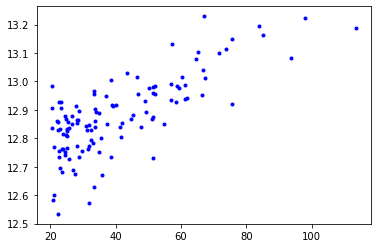

In [70]:
plt.plot(dfr[d2d.value < 10e-2].LAMBDA, cluster_center.iloc[idx][d2d.value < 10e-2].corrected_neighbor_mass, ".b")
plt.show()

In [67]:
#Mandelbaum et al total mass
np.log10(10**(14.344)*(dfr.LAMBDA/40)**(1.33))

301      14.463233
651      14.946488
730      14.548541
1649     14.566651
1818     14.680753
           ...    
24759    14.075497
25017    14.043785
25140    13.975441
25209    14.140746
25571    14.561988
Name: LAMBDA, Length: 120, dtype: float32

In [56]:
dfr[np.logical_and(d2d.value > 1e-2, np.abs(cluster_center.iloc[idx].z_phot_median.to_numpy()-dfr.Z_LAMBDA.to_numpy()) > 0.1)].head(1).T

,6548
ID,8761
NAME,b'RMJ002842.2-023750.4'
RA,7.17564
DEC,-2.63066
Z_LAMBDA,0.383463
Z_LAMBDA_ERR,0.0172385
LAMBDA,23.146
LAMBDA_ERR,3.79495
S,1.11574
Z_SPEC,0.339258


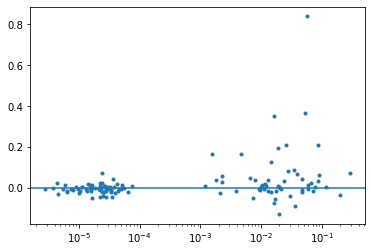

In [33]:
plt.semilogx(d2d.value, cluster_center.iloc[idx].z_phot_median.to_numpy()-dfr.Z_LAMBDA.to_numpy(), ".")
plt.axhline(0)
plt.show()

[]

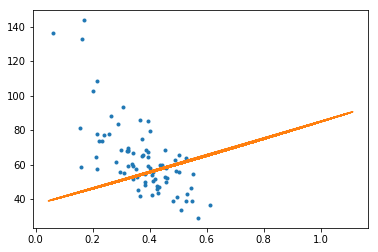

In [58]:
plt.plot(cluster_center.iloc[idx][d2d.value < 10e-3].z_phot_median, cluster_center.iloc[idx][d2d.value < 10e-3].neighbors, ".")
plt.plot(cluster_center.z_phot_median, (2*(1 + cluster_center.z_phot_median)**1.2*np.median(cluster_center.neighbors))/(1 + 0.5)**1.2)
plt.plot()

In [59]:
cluster_center.iloc[idx][np.logical_and(d2d.value > 1e-2, np.abs(cluster_center.iloc[idx].z_phot_median.to_numpy()-dfr.Z_LAMBDA.to_numpy()) > 0.1)][["RA", "DEC", "z_phot_median", "mass", "local_neighbor_mass"]].head(60)

,RA,DEC,z_phot_median,mass,local_neighbor_mass
2392,1.909043,-3.732939,0.743842,11.252232,11.994575
1484,7.079611,-2.542645,0.540162,11.259544,12.201780
286,7.165872,-2.613379,0.253965,11.718165,12.428108
1648,5.027015,-4.732049,0.544332,11.435161,12.177110
898,8.671347,-1.970504,0.322315,11.517843,12.294542
2331,8.322156,-0.479610,0.574869,11.372211,12.022066
2377,2.750671,-1.006892,0.607316,11.233842,12.001653
1488,9.284121,-2.086818,0.676149,11.349512,12.201250
1250,8.946741,-2.839486,0.802279,11.376121,12.239980


In [60]:
dfr[np.logical_and(d2d.value > 1e-2, np.abs(cluster_center.iloc[idx].z_phot_median.to_numpy()-dfr.Z_LAMBDA.to_numpy()) > 0.1)][["RA", "DEC", "Z_LAMBDA"]].head(60)

,RA,DEC,Z_LAMBDA
3864,1.927496,-3.767972,0.252415
4352,7.107742,-2.550961,0.387245
6548,7.175636,-2.630664,0.383463
6655,5.034800,-4.744568,0.416316
7310,8.621469,-1.998840,0.219074
16566,8.337504,-0.490938,0.380243
17877,2.770652,-1.021542,0.446531
20202,9.280182,-1.958092,0.331203
24501,8.941598,-2.786503,0.438626


In [148]:
len(dfr)

120

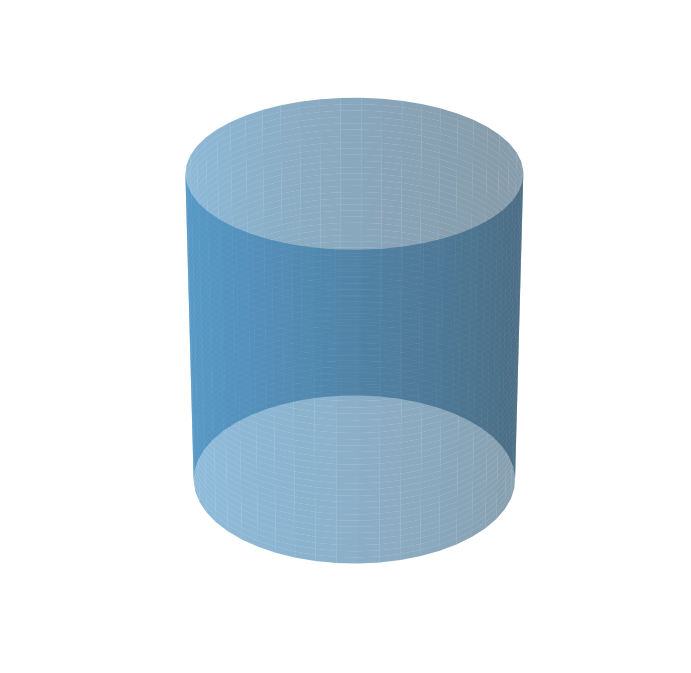

In [23]:
import numpy as np

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection='3d')

Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

plt.axis('off')
plt.show()